In [1]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import gc

import pickle
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
color = sns.color_palette()
sns.set_style("darkgrid")

In [2]:
def change_dtype(df):
    df['timestamp'] = pd.to_datetime(df['timestamp'], format='%Y-%m-%d %H:%M:%S')
    return df

def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

__Using UCF data for site_id 0__ 

Special thanks to <a href="https://www.kaggle.com/gunesevitan/ashrae-ucf-spider-and-eda-full-test-labels/data"> Gunes</a> for this awesome work

In [3]:
# load site 0 data
ext_df = pd.read_pickle('site0.pkl') 
ext_df['meter_reading'] = ext_df.meter_reading_scraped
ext_df.drop(['meter_reading_original','meter_reading_scraped'], axis=1, inplace=True)
ext_df.fillna(0, inplace=True)
ext_df.loc[ext_df.meter_reading < 0, 'meter_reading'] = 0
ext_df = ext_df[ext_df.timestamp.dt.year > 2016]
print(len(ext_df))

2260080


In [4]:
ext_df.sample(5)

,building_id,meter,timestamp,meter_reading
2911933,99,0,2018-08-16 18:00:00,23.674601
1120093,74,0,2017-01-15 00:00:00,164.838294
1255097,23,0,2017-02-27 15:00:00,1027.253112
1426831,53,0,2017-04-24 02:00:00,573.350574
1258368,61,0,2017-02-28 16:00:00,283.262486


In [5]:
df_build = pd.read_csv('building_metadata.csv')
df_weather_train = pd.read_csv('weather_train.csv')
df_train = pd.read_csv('train.csv')
df_weather_test =  pd.read_csv('weather_test.csv')

In [6]:
ucf_year = [2017, 2018] # ucf data year used in train
#Deleting sioi 0 data for 2016
bids = ext_df.building_id.unique()
df_train = df_train[df_train.building_id.isin(bids) == False]

ext_df = ext_df[ext_df.timestamp.dt.year.isin(ucf_year)]

df_train = pd.concat([df_train, ext_df])
df_train.reset_index(inplace=True)

df_weather_train = pd.concat([df_weather_train, df_weather_test])
df_weather_train.reset_index(inplace=True)

In [7]:
del df_weather_test, ext_df
gc.collect()

22

In [8]:
df_train = change_dtype(df_train)
df_weather_train = change_dtype(df_weather_train)

df_train = reduce_mem_usage(df_train)
df_weather_train = reduce_mem_usage(df_weather_train)
df_build= reduce_mem_usage(df_build)

gc.collect()

Mem. usage decreased to 387.76 Mb (52.5% reduction)
Mem. usage decreased to 10.74 Mb (66.2% reduction)
Mem. usage decreased to  0.03 Mb (60.3% reduction)


22

In [9]:
df_train['date'] = df_train['timestamp'].dt.date
df_train['meter_reading_log1p'] = np.log1p(df_train['meter_reading'])

In [10]:
def plot_date_usage(train_df, meter=0, building_id=0):
    fig = plt.figure(figsize=(16, 8))
    train_temp_df = train_df[train_df['meter'] == meter]
    train_temp_df = train_temp_df[train_temp_df['building_id'] == building_id]    
    train_temp_df_meter = train_temp_df.groupby('date')['meter_reading_log1p'].sum()
    train_temp_df_meter = train_temp_df_meter.to_frame().reset_index()
    sns.lineplot(x=train_temp_df_meter['date'], y=train_temp_df_meter['meter_reading_log1p'])
    plt.show()

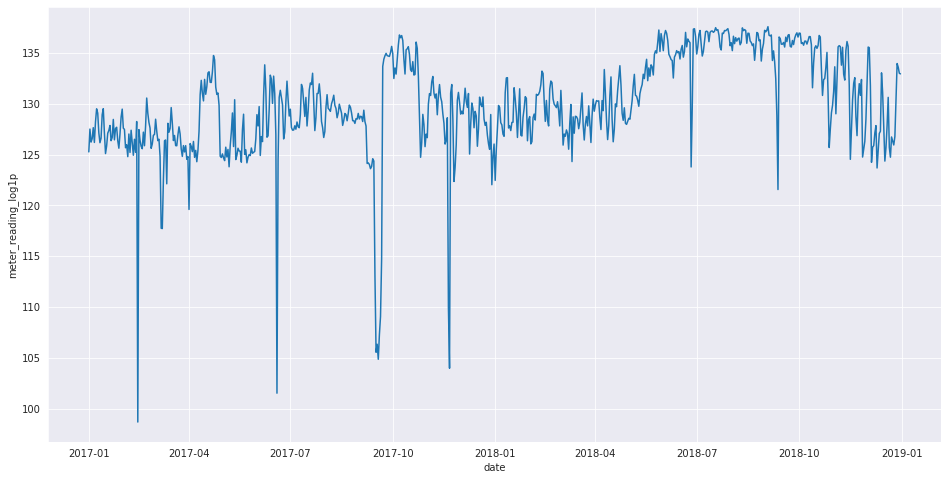

In [11]:
plot_date_usage(df_train, meter=0, building_id=0)

### Removing data of site 0 till 20th of May 2016 for electricity meter

In [12]:
df_train = df_train.query('not (building_id <= 104 & meter == 0 & timestamp <= "2016-05-20")')

__As we already know weather has lot's of NaNs, We will fill Nan using Interpolation__

In [13]:
def fill_weather(df):
    df = df.groupby('site_id').apply(lambda group: group.interpolate(limit_direction='both'))
    return df

In [14]:
df_weather_train = fill_weather(df_weather_train)

In [15]:
df_weather_train.groupby('site_id').apply(lambda group: group.isna().sum())

,index,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
site_id,,,,,,,,,,
0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,26050,0,0,0
2,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,25996,25996,0,0
6,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,25187,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0


We can see that some sites dosen't have any information for some of the features hence we are still getting NaNs

In [16]:
def pre_preprocess_data(df, test=False):
    
    """
    Preparing final dataset with all features.
    """
#     df.square_feet = np.log1p(df.square_feet)
    
    if not test:
        df.sort_values("timestamp", inplace=True)
        df.reset_index(drop=True, inplace=True)
    
#     holidays = ["2016-01-01", "2016-01-18", "2016-02-15", "2016-05-30", "2016-07-04",
#                 "2016-09-05", "2016-10-10", "2016-11-11", "2016-11-24", "2016-12-26",
#                 "2017-01-01", "2017-01-16", "2017-02-20", "2017-05-29", "2017-07-04",
#                 "2017-09-04", "2017-10-09", "2017-11-10", "2017-11-23", "2017-12-25",
#                 "2018-01-01", "2018-01-15", "2018-02-19", "2018-05-28", "2018-07-04",
#                 "2018-09-03", "2018-10-08", "2018-11-12", "2018-11-22", "2018-12-25",
#                 "2019-01-01"]
    
    df["hour"] = df["timestamp"].dt.hour
    df["weekend"] = df["timestamp"].dt.weekday
    df["month"] = df["timestamp"].dt.month
    df["dayofweek"] = df["timestamp"].dt.dayofweek
#     df["is_holiday"] = (df.timestamp.dt.date.astype("str").isin(holidays)).astype(int)

    df_group = df.groupby('building_id')['meter_reading_log1p']
    building_median = df_group.median().astype(np.float16)
    df['building_median'] = df['building_id'].map(building_median)
    
    del df_group
    gc.collect()

    return df, building_median

In [17]:
df_train, building_median = pre_preprocess_data(df_train)

In [18]:
picfile = open('buildings.pkl', 'wb')
pickle.dump(building_median, picfile)
picfile.close()

In [19]:
df_train.head()

,index,building_id,meter,timestamp,meter_reading,date,meter_reading_log1p,hour,weekend,month,dayofweek,building_median
0,103,105,0,2016-01-01,23.303600,2016-01-01,3.190624,0,4,1,4,4.332031
1,1577,1123,0,2016-01-01,27.444000,2016-01-01,3.347937,0,4,1,4,3.533203
2,1576,1122,1,2016-01-01,0.000000,2016-01-01,0.000000,0,4,1,4,4.144531
3,1575,1122,0,2016-01-01,70.580002,2016-01-01,4.270816,0,4,1,4,4.144531
4,1574,1121,2,2016-01-01,1570.310059,2016-01-01,7.359665,0,4,1,4,5.101562


In [20]:
category_cols = ['building_id', 'site_id', 'primary_use']
feature_cols = ['square_feet'] + [
    'hour', 'weekend',
    'building_median'] + [
    'air_temperature', 'cloud_coverage',
    'dew_temperature', 'precip_depth_1_hr', 'sea_level_pressure',
    'wind_direction', 'wind_speed']

In [21]:
from sklearn.preprocessing import LabelEncoder

In [22]:
le = LabelEncoder()
df_build.primary_use = le.fit_transform(df_build.primary_use)

In [23]:
def create_X_y(train_df):
    
    target_train_df = train_df
    target_train_df = target_train_df.merge(df_build, on='building_id', how='left')
    target_train_df = target_train_df.merge(df_weather_train, on=['site_id', 'timestamp'], how='left')
    target_train_df.square_feet = np.log1p(target_train_df.square_feet)
    
    X_train = target_train_df[feature_cols + category_cols]
    y_train = target_train_df['meter_reading_log1p'].values
    
    del target_train_df
    gc.collect()
    return X_train, y_train

In [24]:
X, y = create_X_y(df_train)

In [25]:
# X.drop('year_built', inplace=True, axis=1)

In [26]:
X.head()

,square_feet,hour,weekend,building_median,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,building_id,site_id,primary_use
0,10.832181,0,4,4.332031,3.800781,0.0,2.400391,NaN,1021.0,240.0,3.099609,105,1,0
1,11.440301,0,4,3.533203,-8.296875,8.0,-12.203125,-1.0,1023.5,250.0,4.101562,1123,13,6
2,11.342920,0,4,4.144531,-8.296875,8.0,-12.203125,-1.0,1023.5,250.0,4.101562,1122,13,6
3,11.342920,0,4,4.144531,-8.296875,8.0,-12.203125,-1.0,1023.5,250.0,4.101562,1122,13,6
4,11.358993,0,4,5.101562,-8.296875,8.0,-12.203125,-1.0,1023.5,250.0,4.101562,1121,13,0


In [27]:
X_1st_half =  X[:int(X.shape[0] / 2)]
X_2nd_half =  X[int(X.shape[0] / 2):]

y_1st_half = y[:int(X.shape[0] / 2)]
y_2nd_half = y[int(X.shape[0] / 2):]

In [28]:
del X, y
gc.collect()

88

In [29]:
import lightgbm as lgb
import random
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
random.seed(12)

In [30]:
def fit_lgbm(train, val, devices=(-1,), seed=None, cat_features=None, num_rounds=1500, lr=0.1, bf=0.1):
    """Train Light GBM model"""
    X_train, y_train = train
    X_valid, y_valid = val
    metric = 'l2'
    params = {'num_leaves': 31,
              'objective': 'regression',
              'learning_rate': lr,
              "boosting": "gbdt",
              "bagging_freq": 5,
              "bagging_fraction": bf,
              "feature_fraction": 0.9,
              "metric": metric,
              }
    device = devices[0]
    if device == -1:
        # use cpu
        pass
    else:
        # use gpu
        print(f'using gpu device_id {device}...')
        params.update({'device': 'gpu', 'gpu_device_id': device})

    params['seed'] = seed

    early_stop = 20
    verbose_eval = 20

    d_train = lgb.Dataset(X_train, label=y_train, categorical_feature=cat_features)
    d_valid = lgb.Dataset(X_valid, label=y_valid, categorical_feature=cat_features)
    watchlist = [d_train, d_valid]

    print('training LGB:')
    model = lgb.train(params,
                      train_set=d_train,
                      num_boost_round=num_rounds,
                      valid_sets=watchlist,
                      verbose_eval=verbose_eval,
                      early_stopping_rounds=early_stop)

    # predictions
    y_pred_valid = model.predict(X_valid, num_iteration=model.best_iteration)
    
    print('best_score', model.best_score)
    log = {'train/mae': model.best_score['training']['l2'],
           'valid/mae': model.best_score['valid_1']['l2']}
    return model, y_pred_valid, log

In [31]:
folds = 5
num_rounds=2000
seed = 666
shuffle = False
kf = KFold(n_splits=folds, shuffle=shuffle, random_state=seed)
oof_total = 0

### Traning Model for meter 0

1st of the data (10699759, 14)
cat_features [11, 12, 13]
train 8559807 valid 2139952
training LGB:
Training until validation scores don't improve for 20 rounds
[20]	training's l2: 2.50464	valid_1's l2: 3.02355
[40]	training's l2: 2.22549	valid_1's l2: 2.79985
[60]	training's l2: 2.15339	valid_1's l2: 2.74693
[80]	training's l2: 2.1049	valid_1's l2: 2.70395
[100]	training's l2: 2.05993	valid_1's l2: 2.63853
[120]	training's l2: 2.03123	valid_1's l2: 2.60463
[140]	training's l2: 2.01278	valid_1's l2: 2.58871
[160]	training's l2: 1.99761	valid_1's l2: 2.56961
[180]	training's l2: 1.98539	valid_1's l2: 2.5567
[200]	training's l2: 1.97584	valid_1's l2: 2.55072
[220]	training's l2: 1.9677	valid_1's l2: 2.54434
[240]	training's l2: 1.96105	valid_1's l2: 2.54276
[260]	training's l2: 1.95528	valid_1's l2: 2.53888
[280]	training's l2: 1.9498	valid_1's l2: 2.53515
[300]	training's l2: 1.94669	valid_1's l2: 2.53479
[320]	training's l2: 1.94304	valid_1's l2: 2.53246
[340]	training's l2: 1.9396	vali

10

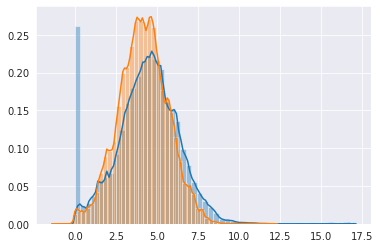

In [32]:
target_meter = 0
X_train, y_train = X_1st_half, y_1st_half
y_valid_pred_total = np.zeros(X_train.shape[0])
gc.collect()
print('1st of the data', X_1st_half.shape)

cat_features = [X_train.columns.get_loc(cat_col) for cat_col in category_cols]
print('cat_features', cat_features)

models0 = []
for train_idx, valid_idx in kf.split(X_train, y_train):
    train_data = X_train.iloc[train_idx,:], y_train[train_idx]
    valid_data = X_train.iloc[valid_idx,:], y_train[valid_idx]

    print('train', len(train_idx), 'valid', len(valid_idx))
    model, y_pred_valid, log = fit_lgbm(train_data, valid_data, cat_features=category_cols,
                                        num_rounds=num_rounds, lr=0.05, bf=0.7)
    y_valid_pred_total[valid_idx] = y_pred_valid
    models0.append(model)
    gc.collect()
    
sns.distplot(y_train, label= "Original Data")
sns.distplot(y_valid_pred_total, label= "Prediction")
plt.legend(loc="upper left")
plt.show()

oof0 = mean_squared_error(y_train, y_valid_pred_total)
oof_total += oof0 * len(y_train)

del X_train, y_train, X_1st_half, y_1st_half
gc.collect()

1st of the data (10699759, 14)
cat_features [11, 12, 13]
train 8559807 valid 2139952
training LGB:
Training until validation scores don't improve for 20 rounds
[20]	training's l2: 2.49661	valid_1's l2: 2.62062
[40]	training's l2: 2.18194	valid_1's l2: 2.39568
[60]	training's l2: 2.09561	valid_1's l2: 2.32783
[80]	training's l2: 2.03533	valid_1's l2: 2.2739
[100]	training's l2: 1.99851	valid_1's l2: 2.24097
[120]	training's l2: 1.97301	valid_1's l2: 2.21758
[140]	training's l2: 1.95599	valid_1's l2: 2.20508
[160]	training's l2: 1.94226	valid_1's l2: 2.1998
[180]	training's l2: 1.92798	valid_1's l2: 2.205
Early stopping, best iteration is:
[163]	training's l2: 1.94092	valid_1's l2: 2.19898
best_score defaultdict(<class 'collections.OrderedDict'>, {'training': OrderedDict([('l2', 1.9409220902192204)]), 'valid_1': OrderedDict([('l2', 2.1989766718427153)])})
train 8559807 valid 2139952
training LGB:
Training until validation scores don't improve for 20 rounds
[20]	training's l2: 2.50571	val

NameError: name 'X_1st_half' is not defined

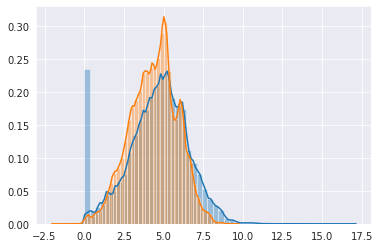

In [33]:
target_meter = 1
X_train, y_train = X_2nd_half, y_2nd_half
y_valid_pred_total = np.zeros(X_train.shape[0])
gc.collect()
print('1st of the data', X_2nd_half.shape)

cat_features = [X_train.columns.get_loc(cat_col) for cat_col in category_cols]
print('cat_features', cat_features)

models1 = []
for train_idx, valid_idx in kf.split(X_train, y_train):
    train_data = X_train.iloc[train_idx,:], y_train[train_idx]
    valid_data = X_train.iloc[valid_idx,:], y_train[valid_idx]

    print('train', len(train_idx), 'valid', len(valid_idx))
    model, y_pred_valid, log = fit_lgbm(train_data, valid_data, cat_features=category_cols,
                                        num_rounds=num_rounds, lr=0.05, bf=0.7)
    y_valid_pred_total[valid_idx] = y_pred_valid
    models1.append(model)
    gc.collect()

sns.distplot(y_train, label= "Original Data")
sns.distplot(y_valid_pred_total, label= "Prediction")
plt.legend(loc="upper left")
plt.show()

oof1 = mean_squared_error(y_train, y_valid_pred_total)
oof_total += oof1 * len(y_train)

del X_train, y_train, X_2nd_half, y_2nd_half
gc.collect()

In [37]:
##oof Scores

print ('oof score meter0 =', np.sqrt(oof0))
print ('oof score meter1 =', np.sqrt(oof1))
print ('oof score total  =', np.sqrt(oof_total / len(df_train)))

oof score meter0 = 1.4790247463397375
oof score meter1 = 1.4882114369520931
oof score total  = 1.48362520222601


In [ ]:
models = [models0, models1]

picfile = open('models.pkl', 'wb')
pickle.dump(models, picfile)
picfile.close()

picfile = open('le.pkl', 'wb')
pickle.dump(le, picfile)
picfile.close()

In [ ]:
del df_train, df_weather_train, df_build
gc.collect()

In [ ]:
picfile = open('models.pkl', 'rb')
models = pickle.load(picfile)
picfile.close()

picfile = open('le.pkl', 'rb')
le = pickle.load(picfile)
picfile.close()

with open('buildings.pkl', 'rb') as file:
    building_median = pickle.load(file)

In [ ]:
df_test = pd.read_csv('test.csv')
df_weather_test = pd.read_csv('weather_test.csv')
df_build = pd.read_csv('building_metadata.csv')

df_test = change_dtype(df_test)
df_weather_test = change_dtype(df_weather_test)

df_test = reduce_mem_usage(df_test)
df_weather_test = reduce_mem_usage(df_weather_test)
df_build= reduce_mem_usage(df_build)

gc.collect()

In [ ]:
df_test['date'] = df_test['timestamp'].dt.date

In [ ]:
df_test["hour"] = df_test["timestamp"].dt.hour
df_test["weekend"] = df_test["timestamp"].dt.weekday
df_test["month"] = df_test["timestamp"].dt.month
df_test["dayofweek"] = df_test["timestamp"].dt.dayofweek
df_test['building_median'] = df_test['building_id'].map(building_median)

In [ ]:
df_test.dtypes

In [ ]:
df_weather_test = df_weather_test.groupby('site_id').apply(lambda group: group.interpolate(limit_direction='both'))

In [ ]:
sample_submission = pd.read_csv('sample_submission.csv')
sample_submission = reduce_mem_usage(sample_submission)

gc.collect()

In [ ]:
df_build.primary_use = le.transform(df_build.primary_use)

In [ ]:
def create_X(test_df):
    
    target_test_df = test_df
    target_test_df = target_test_df.merge(df_build, on='building_id', how='left')
    target_test_df = target_test_df.merge(df_weather_test, on=['site_id', 'timestamp'], how='left')
    target_test_df.square_feet = np.log1p(target_test_df.square_feet)
    X_test = target_test_df[feature_cols + category_cols]
    return X_test

In [ ]:
from tqdm import tqdm_notebook as tqdm

In [ ]:
def pred(X_test, models, batch_size=1000000):
    iterations = (X_test.shape[0] + batch_size -1) // batch_size
    print('iterations', iterations)

    y_test_pred_total = np.zeros(X_test.shape[0])
    for i, model in enumerate(models):
        print(f'predicting {i}-th model')
        for k in tqdm(range(iterations)):
            y_pred_test = model.predict(X_test[k*batch_size:(k+1)*batch_size], num_iteration=model.best_iteration)
            y_test_pred_total[k*batch_size:(k+1)*batch_size] += y_pred_test

    y_test_pred_total /= len(models)
    return y_test_pred_total

In [ ]:
X_test = create_X(df_test)
gc.collect()

In [ ]:
y_test = pred(X_test, models[0])

sns.distplot(y_test)
plt.show()
gc.collect()

In [ ]:
sample_submission['meter_reading'] = np.expm1(y_test)

In [ ]:
sample_submission.to_csv('submission1.csv', index=False, float_format='%.4f')

In [ ]:
leak_score = 0

leak_df = pd.read_pickle('site0.pkl') 
leak_df['meter_reading'] = leak_df.meter_reading_scraped
leak_df.drop(['meter_reading_original','meter_reading_scraped'], axis=1, inplace=True)
leak_df.fillna(0, inplace=True)
leak_df = leak_df[leak_df.timestamp.dt.year > 2016]
leak_df.loc[leak_df.meter_reading < 0, 'meter_reading'] = 0 # remove large negative values

sample_submission.loc[sample_submission.meter_reading < 0, 'meter_reading'] = 0

for bid in leak_df.building_id.unique():
    temp_df = leak_df[(leak_df.building_id == bid)]
    for m in temp_df.meter.unique():
        v0 = sample_submission.loc[(df_test.building_id == bid)&(df_test.meter==m), 'meter_reading'].values
        v1 = temp_df[temp_df.meter==m].meter_reading.values
        
        leak_score += mean_squared_error(np.log1p(v0), np.log1p(v1)) * len(v0)
        
        sample_submission.loc[(df_test.building_id == bid)&(df_test.meter==m), 'meter_reading'] = temp_df[temp_df.meter==m].meter_reading.values

In [ ]:
sample_submission.to_csv('submission2.csv', index=False, float_format='%.4f')

In [ ]:
sample_submission['meter_reading'].max()